# Financial Fraud Detection

The recent past has shown an increase in financial transactions through the internet, like e-commerce, banking, etc., which raise concerns about fraud. Companies have invested a lot of resources in approaches to identify fraud, but rule-based tools are not flexible and a criminal can learn how to work around them.  Machine Learning is an interesting tool that can help with this task and there are many suitable approaches we can use.
In this project, I'm going to build a machine learning model with the purpose of identifying fraud. I'm going to use the Synthetic Financial Dataset For Fraud Detection generated by the PaySim mobile money simulator, available at [Kaggle](https://www.kaggle.com/ntnu-testimon/paysim1).

## Variables

Description of the Variables

    * step: Maps a unit of time in the real world. In this case 1 step is 1 hour of time.
    * type: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER
    * amount: amount of the transaction in local currency
    * nameOrig: customer who started the transaction
    * oldbalanceOrg: initial balance before the transaction
    * newbalanceOrig: customer's balance after the transaction.
    * nameDest: recipient ID of the transaction.
    * oldbalanceDest: initial recipient balance before the transaction.
    * newbalanceDest: recipient's balance after the transaction.
    * isFraud: identifies a fraudulent transaction (1) and non fraudulent (0)
    * isFlaggedFraud: flags illegal attempts to transfer more than 200.000 in a single transaction.

## Exploratory Data Analysis

Before we dive into the machine learning model, let's explore the data and get some insights.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import scipy.stats
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz 

%matplotlib inline

# load data
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


* How many transactions are there?
* Are there missing values?
* How many unique values in each category?

In [2]:
print('Number of Transactions and Variables')
print(df.shape)

print('Missing Values')
print(df.isnull().sum())

print('Unique values in each category')
print(df.nunique())

Number of Transactions and Variables
(6362620, 11)
Missing Values
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
Unique values in each category
step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64


* How many fraudulent transactions?

In [3]:
# How many fraudulent transactions?
df['isFraud'].value_counts(dropna=False)

0    6354407
1       8213
Name: isFraud, dtype: int64

#### Let's explore the amount of the transactions.
* What is the distribution according to type?
* What is the average amount according to the type of transaction?
* Are they different? Is this difference statistically significant?

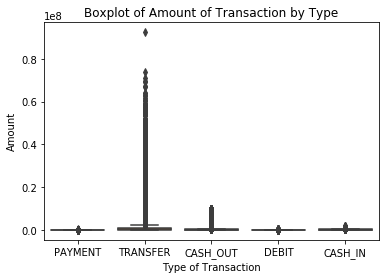

In [4]:
# Distribution of transaction types
sns.boxplot(x='type', y = 'amount', data = df)
plt.xlabel('Type of Transaction')
plt.ylabel('Amount')
plt.title('Boxplot of Amount of Transaction by Type');

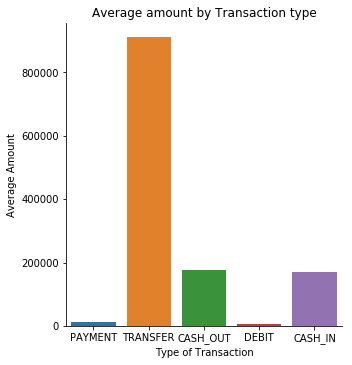

In [5]:
#This graph shows the transaction average amount according to type
sns.catplot(x="type", y="amount", data=df, kind="bar", ci=None)
plt.xlabel('Type of Transaction')
plt.ylabel('Average Amount')
plt.title('Average amount by Transaction type');

There is a difference in the average amount of the transactions. To evaluate if this difference is significant, we can use Anova. 

**Null and Alternative Hypothesis**

$\mu_0$:All means are equal
    
$\mu_1$:At least one mean is different

In [6]:
anova_1 = smf.ols(formula = 'amount ~ C(type)',data=df).fit()

print(anova_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                 2.787e+05
Date:                Sun, 09 Dec 2018   Prob (F-statistic):               0.00
Time:                        11:45:20   Log-Likelihood:            -9.3208e+07
No. Observations:             6362620   AIC:                         1.864e+08
Df Residuals:                 6362615   BIC:                         1.864e+08
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.689e+05    

The Prob (F-statistic)< 0.05, we reject $\mu_0$, so at least one mean is different. But which one? Let's perform the Tukey's Test to verify. As you can see, all the means are different from each other.

In [7]:
#Post hoc test 
c1 = multi.MultiComparison(df['amount'],df['type'])
res1 = c1.tukeyhsd()
print(res1.summary())

       Multiple Comparison of Means - Tukey HSD,FWER=0.05      
 group1   group2    meandiff      lower        upper     reject
---------------------------------------------------------------
CASH_IN  CASH_OUT  7353.7223    5716.1348    8991.3099    True 
CASH_IN   DEBIT   -163436.5767 -171010.982  -155862.1714  True 
CASH_IN  PAYMENT  -155862.6373 -157512.7703 -154212.5043  True 
CASH_IN  TRANSFER 741726.7676   739280.939  744172.5963   True 
CASH_OUT  DEBIT   -170790.299  -178323.793  -163256.8051  True 
CASH_OUT PAYMENT  -163216.3597 -164667.1715 -161765.5479  True 
CASH_OUT TRANSFER 734373.0453  732057.0156   736689.075   True 
 DEBIT   PAYMENT   7573.9393     37.7084     15110.1703   True 
 DEBIT   TRANSFER 905163.3443  897413.8982  912912.7905   True 
PAYMENT  TRANSFER  897589.405  895264.4879  899914.3221   True 
---------------------------------------------------------------


* Is the average amount of the transactions different for fraudulent and non-fraudulent ones?
* Is this difference statistically significant?

Let's use Anova again.

$\mu_0$:The means are equal
    
$\mu_1$:The means are different

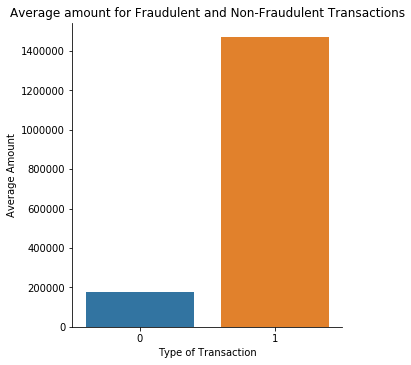

In [8]:
# What are the average amounts of fraudulent/non-fraudulent transactions?
sns.catplot(x="isFraud", y="amount", data=df, kind="bar", ci=None)
plt.xlabel('Type of Transaction')
plt.ylabel('Average Amount')
plt.title('Average amount for Fraudulent and Non-Fraudulent Transactions');

In [9]:
anova_2 = smf.ols(formula = 'amount ~ C(isFraud)',data=df).fit()

print(anova_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 amount   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                 3.764e+04
Date:                Sun, 09 Dec 2018   Prob (F-statistic):               0.00
Time:                        11:51:07   Log-Likelihood:            -9.3703e+07
No. Observations:             6362620   AIC:                         1.874e+08
Df Residuals:                 6362618   BIC:                         1.874e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.782e+05    238.845    7

Yes, Fraudulent Transactions have a higher average amount.

#### Let's evaluate the relationship between the type of transaction and the Fraud/No-Fraud status.

* Is there any type of transactions which is more probable of being Fraud? Which one(s)?
* Is this association statistically significant?

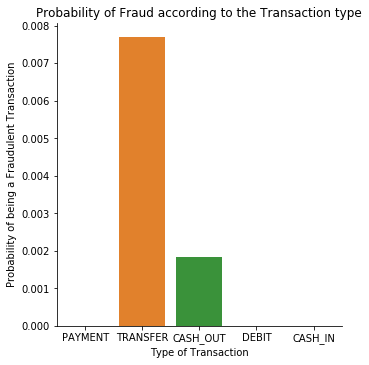

In [10]:
#This graph shows the probability of being a fraudulent transaction according to the type of transaction
sns.catplot(x="type", y="isFraud", data=df, kind="bar", ci=None)
plt.xlabel('Type of Transaction')
plt.ylabel('Probability of being a Fraudulent Transaction')
plt.title('Probability of Fraud according to the Transaction type');

We are evaluating the association of 2 categorical variables, type and isFraud, so, we are going to use the $X^2$ test.

**Null and Alternative Hypothesis**

$\mu_0$:There is no association between the type of transaction and Fraud
    
$\mu_1$:There is association between the type of transaction and Fraud


In [11]:
# cross table
ct1 = pd.crosstab(df['isFraud'],df['type'])
# chi-square test
cs1 = scipy.stats.chi2_contingency(ct1)
print(cs1)

(22082.53571319108, 0.0, 4, array([[1.39747778e+06, 2.23461179e+06, 4.13785187e+04, 2.14871781e+06,
        5.32221110e+05],
       [1.80622440e+03, 2.88821075e+03, 5.34812728e+01, 2.77719374e+03,
        6.87889834e+02]]))


the p-value < 0.05 (the second value 0.0), so, there is an association between fraudulent transactions and the type of transaction

#### Distribution of the transaction amounts for fraudulent and non-fraudulent ones

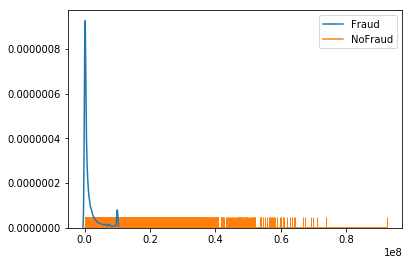

In [12]:
# Analyze data for fraudulent and non-fraudulent transactions
# There is Fraud
yes = df.loc[df['isFraud'] == 1]
# No Fraud
no = df.loc[df['isFraud'] == 0]

# Distribution of transaction amount 
sns.distplot(yes[['amount']],label = 'Fraud', hist=False, rug=True)
sns.distplot(no[['amount']],label = 'NoFraud', hist=False, rug=True)
plt.legend();

#### Flagged Transactions

* How many fraudulent transactions were flagged?
* Was there any non-fraudulent transaction flagged by mistake?


In [13]:
print('Fraudulent transactions which were flagged')
print(yes['isFlaggedFraud'].value_counts())
print(' ')
print('Transactions flagged by mistake')
print(no['isFlaggedFraud'].value_counts())

Fraudulent transactions which were flagged
0    8197
1      16
Name: isFlaggedFraud, dtype: int64
 
Transactions flagged by mistake
0    6354407
Name: isFlaggedFraud, dtype: int64


### Insights
* The dataset contains 6,362,620 instances, and 8213 of them are fraudulent transactions
* There are no missing values
* From those 8,213 fraudulent transactions, only 16 were flagged
* The amount of the transaction ranges from 0 to 92,445,516.64
* Transactions like transfer and cash-out have a lot of outliers
* Transfer transactions have the highest probability of being Fraud, followed by Cash-Out transactions
* Transfer transactions have the largest average amount 
* Fraudulent transactions have higher average amounts than non-fraudulent ones
* The distribution of fraudulent transaction amounts is right-skewed
* The distribution of non-fraudulent transaction amounts is closer to a uniform distribution, but it has some outliers

## Machine Learning Modelling

#### Preparing and Splitting Data
 Before the modeling, we need to prepare the data. So, for the features matrix, I'm going to exclude the isFraud variable, because it is the target, and also the isFlaggedFraud because the algorithm is supposed to do that. Also, I'm going to exclude the origin and destination accounts and the step. 

In [14]:
# Prepare and split the data
# target 
y = df['isFraud'].values
# features
df_to_np = df.drop(['step','isFraud','isFlaggedFraud', 'nameOrig','nameDest'], axis=1)
# dummies for type
df_to_np = pd.get_dummies(df_to_np, prefix=['type'])
# features matrix
X = df_to_np.values

In [15]:
# split the data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#### Algorithm and Metrics
I tested some algorithms like Naive Bayes and Logistic Regression, but the Decision Tree gave me the best result.
As the dataset is unbalanced, we can't use the accuracy to evaluate the predictions. Precision, Recall, F1 score, and AUC are the metrics that I used to compare the models.

In [16]:
# Decision Tree Classifier
clf = DecisionTreeClassifier().fit(X_train,y_train)
pred = clf.predict(X_test)
print('Precision',precision_score(y_test,pred))
print('Recall',recall_score(y_test,pred))
print('F1 Score',f1_score(y_test,pred))

Precision 0.9069575957184026
Recall 0.8940746753246753
F1 Score 0.9004700592683424


In [17]:
# Save the tree in pdf 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render('Fraud Detection') 

'Fraud Detection.pdf'

Area under the Curve 0.9469780612127137


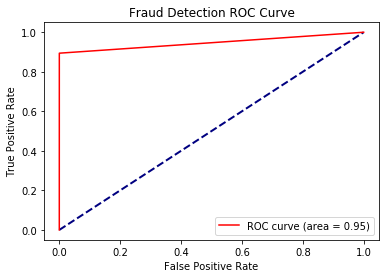

In [18]:
# ROC Curve
predictions = clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, predictions[:,1])
print ('Area under the Curve',roc_auc)

fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr, tpr, color='red', label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Fraud Detection ROC Curve')
plt.legend(loc="lower right")
plt.show()

## Summary

* In this project, I used the Synthetic Financial Dataset For Fraud Detection, generated by the PaySim mobile money simulator, to build a Machine Learning model to identify Fraud.
* The dataset is unbalanced, having more than 99% of the data from 1 class
* To split the data, I used the Stratified Shuffle Split method that keeps the ratio of the classes
* The algorithm that gave me the best result was the Decision Tree Classifier
* The AUC and the F1 score indicate a reasonable model. There is, however, room for improvement since I didn't tune any parameter.
* Finally, it's important to remember that this is a synthetic dataset and it can have simpler patterns than a real financial dataset.